# Collaborative filtering project

In this project, the task is to create a paper recommendation system. The system consists of 10,000 scientists and 1,000 papers. Scientists give ratings between 1–5 to the papers that they read. Since not all scientists have read every paper, we only have a limited amount of observations of these ratings. Additionally, each scientist has a wishlist of papers that they would like to read in the future. Your task is to fill in the missing observations using the provided rating and wishlist data, such that we can recommend papers to scientists that we expect them to rate highly.

More specifically, there are three data sources:
 - `train_tbr.csv` containing wishlist data.
 - `train_ratings.csv` containing observed rating data.
 - `sample_submission.csv` containing (scientist, paper) pairs that have to be rated for the evaluation of your method.

The data is available at `/cluster/courses/cil/collaborative_filtering/data` and an environment has been prepared for you at `/cluster/courses/cil/envs/collaborative_filtering`. You can activate the environment in your shell by running:
```bash
conda activate /cluster/courses/cil/envs/collaborative_filtering
```
If you wish to use notebooks on the cluster, you need to set the Environment path to `/cluster/courses/cil/envs/collaborative_filtering/bin` and load the `cuda/12.6` module.

**Evaluation**: Your models are evaluated using the root mean-squared error (RMSE) metric. Your grade is determined by a linear interpolation between the easy (grade 4) and hard (grade 6) baselines.

**Rules**: You are only allowed to use the data provided in `train_tbr.csv` and `train_ratings.csv` to make your predictions of `sample_submission.csv`. You are not allowed to use external data sources. But, you are allowed to use pre-trained models, as long as they are available publicly. Furthermore, no external API calls are allowed, except for downloading the weights of pre-trained models.

**We will verify your code for plagiarism and using solutions from previous years.**

[Link to Kaggle competition](https://www.kaggle.com/competitions/ethz-cil-collaborative-filtering-2025)


In [1]:
from typing import Tuple, Callable

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import os

Make sure that results are reproducible by using a seed.

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## Helper functions

In [3]:
DATA_DIR = "data"


def read_data_df() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Reads in data and splits it into training and validation sets with a 75/25 split."""
    
    df = pd.read_csv(os.path.join(DATA_DIR, "train_ratings.csv"))

    # Split sid_pid into sid and pid columns
    df[["sid", "pid"]] = df["sid_pid"].str.split("_", expand=True)
    df = df.drop("sid_pid", axis=1)
    df["sid"] = df["sid"].astype(int)
    df["pid"] = df["pid"].astype(int)
    
    # Split into train and validation dataset
    train_df, valid_df = train_test_split(df, test_size=0.25)
    return train_df, valid_df


def read_data_matrix(df: pd.DataFrame) -> np.ndarray:
    """Returns matrix view of the training data, where columns are scientists (sid) and
    rows are papers (pid)."""

    return df.pivot(index="sid", columns="pid", values="rating").values


def evaluate(valid_df: pd.DataFrame, pred_fn: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> float:
    """
    Inputs:
        valid_df: Validation data, returned from read_data_df for example.
        pred_fn: Function that takes in arrays of sid and pid and outputs their rating predictions.

    Outputs: Validation RMSE
    """
    
    preds = pred_fn(valid_df["sid"].values, valid_df["pid"].values)
    return root_mean_squared_error(valid_df["rating"].values, preds)


def make_submission(pred_fn: Callable[[np.ndarray, np.ndarray], np.ndarray], filename: os.PathLike):
    """Makes a submission CSV file that can be submitted to kaggle.

    Inputs:
        pred_fn: Function that takes in arrays of sid and pid and outputs a score.
        filename: File to save the submission to.
    """
    
    df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

    # Get sids and pids
    sid_pid = df["sid_pid"].str.split("_", expand=True)
    sids = sid_pid[0]
    pids = sid_pid[1]
    sids = sids.astype(int).values
    pids = pids.astype(int).values
    
    df["rating"] = pred_fn(sids, pids)
    df.to_csv(filename, index=False)

## Singular value decomposition

For the first method in this introduction, we will make use of the singular value decomposition (SVD) to construct the optimal rank-$k$ approximation (when measuring the Frobenius norm as error), according to the Eckart-Young theorem. Since the matrix needs to be fully observed in order to make use of SVD, we need to impute the missing values. In this case, we impute values with $3$.

In [4]:
def impute_values(mat: np.ndarray) -> np.ndarray:
    return np.nan_to_num(mat, nan=3.0)

In [5]:
train_df, valid_df = read_data_df()
train_mat = read_data_matrix(train_df)
train_mat = impute_values(train_mat)

### Singular value spectrum

In order to assess which rank $k$ to use for the reconstruction matrix, we look at the spectrum of singular values and look for the "elbow". In this case, we will use $k=2$.

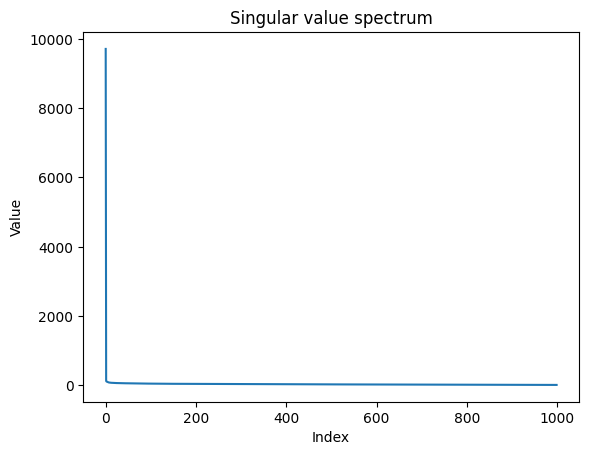

In [6]:
singular_values = np.linalg.svd(train_mat, compute_uv=False, hermitian=False)
plt.plot(singular_values)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Singular value spectrum")
plt.show()

In [7]:
def opt_rank_k_approximation(m: np.ndarray, k: int):
    """Returns the optimal rank-k reconstruction matrix, using SVD."""
    
    assert 0 < k <= np.min(m.shape), f"The rank must be in [0, min(m, n)]"
    
    U, S, Vh = np.linalg.svd(m, full_matrices=False)
    
    U_k = U[:, :k]
    S_k = S[:k]
    Vh_k = Vh[:k]
    
    return np.dot(U_k * S_k, Vh_k)


def matrix_pred_fn(train_recon: np.ndarray, sids: np.ndarray, pids: np.ndarray) -> np.ndarray:
    """
    Input:
        train_recon: (M, N) matrix with predicted values for every (sid, pid) pair.
        sids: (D,) vector with integer scientist IDs.
        pids: (D,) vector with integer paper IDs.
        
    Outputs: (D,) vector with predictions.
    """
    
    return train_recon[sids, pids]

We first obtain the optimal rank-$k$ approximation of the training matrix.

In [8]:
train_recon = opt_rank_k_approximation(train_mat, k=2)

Then, the values of this matrix reconstruction are the predictions for all (sid, pid)-pairs.

In [9]:
pred_fn = lambda sids, pids: matrix_pred_fn(train_recon, sids, pids)

# Evaluate on validation data
val_score = evaluate(valid_df, pred_fn)
print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 1.205


In [10]:
make_submission(pred_fn, "svd_submission.csv")

## Learned embeddings

Next, we will take a machine learning view of the problem. To each scientist and paper, we assign a $d$-dimensional embedding and we predict the rating that the scientist gives the paper to be their dot product. More formally, let $\vec{s}_i$ be a scientist embedding and $\vec{p}_j$ be a paper embedding. Then, we make the following rating prediction for this pair: $$\tilde{r}_{ij} = \langle \vec{s}_i, \vec{p}_j \rangle.$$ We view these embeddings as our learnable parameters and train them as we would any other model using the squared error loss function: $$\ell(\theta) = \frac{1}{2} |\langle \vec{s}_i, \vec{p}_j \rangle - r_{ij}|^2,$$ where $\theta = \{ \vec{s}_i \}_{i=1}^n \cup \{ \vec{p}_j \}_{j=1}^m$. The following is an implementation of this method.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cpu


In [12]:
class EmbeddingDotProductModel(nn.Module):
    def __init__(self, num_scientists: int, num_papers: int, dim: int):
        super().__init__()

        # Assign to each scientist and paper an embedding
        self.scientist_emb = nn.Embedding(num_scientists, dim)
        self.paper_emb = nn.Embedding(num_papers, dim)
        
    def forward(self, sid: torch.Tensor, pid: torch.Tensor) -> torch.Tensor:
        """
        Inputs:
            sid: [B,], int
            pid: [B,], int
        
        Outputs: [B,], float
        """

        # Per-pair dot product
        return torch.sum(self.scientist_emb(sid) * self.paper_emb(pid), dim=-1)

Set $d=32$.

In [13]:
# Define model (10k scientists, 1k papers, 32-dimensional embeddings) and optimizer
model = EmbeddingDotProductModel(10_000, 1_000, 32).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
def get_dataset(df: pd.DataFrame) -> torch.utils.data.Dataset:
    """Conversion from pandas data frame to torch dataset."""
    
    sids = torch.from_numpy(df["sid"].to_numpy())
    pids = torch.from_numpy(df["pid"].to_numpy())
    ratings = torch.from_numpy(df["rating"].to_numpy()).float()
    return torch.utils.data.TensorDataset(sids, pids, ratings)

In [15]:
train_dataset = get_dataset(train_df)
valid_dataset = get_dataset(valid_df)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

Training loop, which we run for 5 epochs.

In [16]:
NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    # Train model for an epoch
    total_loss = 0.0
    total_data = 0
    model.train()
    for sid, pid, ratings in train_loader:
        # Move data to GPU
        sid = sid.to(device)
        pid = pid.to(device)
        ratings = ratings.to(device)

        # Make prediction and compute loss
        pred = model(sid, pid)
        loss = F.mse_loss(pred, ratings)

        # Compute gradients w.r.t. loss and take a step in that direction
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Keep track of running loss
        total_data += len(sid)
        total_loss += len(sid) * loss.item()

    # Evaluate model on validation data
    total_val_mse = 0.0
    total_val_data = 0
    model.eval()
    for sid, pid, ratings in valid_loader:
        # Move data to GPU
        sid = sid.to(device)
        pid = pid.to(device)
        ratings = ratings.to(device)

        # Clamp predictions in [1,5], since all ground-truth ratings are
        pred = model(sid, pid).clamp(1, 5)
        mse = F.mse_loss(pred, ratings)

        # Keep track of running metrics
        total_val_data += len(sid)
        total_val_mse += len(sid) * mse.item()

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train loss={total_loss / total_data:.3f}, Valid RMSE={(total_val_mse / total_val_data) ** 0.5:.3f}")

[Epoch 1/5] Train loss=34.200, Valid RMSE=2.645
[Epoch 2/5] Train loss=16.805, Valid RMSE=2.237
[Epoch 3/5] Train loss=3.165, Valid RMSE=1.158
[Epoch 4/5] Train loss=1.029, Valid RMSE=0.989
[Epoch 5/5] Train loss=0.879, Valid RMSE=0.955


As we can see, this method already provides an improvement on the validation dataset over the naive SVD method.

In [17]:
pred_fn = lambda sids, pids: model(torch.from_numpy(sids).to(device), torch.from_numpy(pids).to(device)).clamp(1, 5).cpu().numpy()

# Evaluate on validation data
with torch.no_grad():
    val_score = evaluate(valid_df, pred_fn)

print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 0.955


In [18]:
with torch.no_grad():
    make_submission(pred_fn, "learned_embedding_submission.csv")

## Outlook

To further improve the score, students can make use of the information in `train_tbr.csv`, which contains the papers that scientists want to read. Furthermore, students can look into more modern collaborative filtering methods and techniques.

Have fun :)

iterative SVD

In [19]:
def iterative_svd(df, k=2, max_iterations=10, tolerance=0.001):
    """
    Performs iterative SVD to improve missing value imputation.
    
    Args:
        df: DataFrame containing ratings
        k: Rank of the approximation
        max_iterations: Maximum number of iterations
        tolerance: Convergence threshold
        
    Returns:
        Reconstructed matrix with predicted ratings
    """
    # Get initial matrix view with missing values
    mat = read_data_matrix(df)
    
    # Keep track of the original missing value positions
    missing_mask = np.isnan(mat)
    
    # Initial imputation (using mean value 3.0 as in the original notebook)
    imputed_mat = impute_values(mat)
    
    # Iteratively refine the matrix
    for iteration in range(max_iterations):
        # Remember previous matrix to check for convergence
        previous_mat = imputed_mat.copy()
        
        # Perform SVD and get reconstruction
        reconstructed_mat = opt_rank_k_approximation(imputed_mat, k)
    
        # Update imputed matrix: keep original values, use SVD predictions for missing values
        imputed_mat = mat.copy()
        imputed_mat[missing_mask] = reconstructed_mat[missing_mask]
        
        # Check for convergence (only on the missing values)
        diff = np.linalg.norm(reconstructed_mat[missing_mask] - previous_mat[missing_mask])
        print(f"Iteration {iteration+1}, Change: {diff:.6f}")
        
        if diff < tolerance:
            print(f"Converged after {iteration+1} iterations")
            break
            
    return imputed_mat

In [20]:
train_df, valid_df = read_data_df()

In [21]:
# Run iterative SVD with rank k=2
final_mat = iterative_svd(train_df, k=2, max_iterations=100, tolerance=0.0001)

Iteration 1, Change: 306.592956
Iteration 2, Change: 250.110051
Iteration 3, Change: 209.600076
Iteration 4, Change: 179.265182
Iteration 5, Change: 155.794911
Iteration 6, Change: 137.151438
Iteration 7, Change: 122.014597
Iteration 8, Change: 109.496081
Iteration 9, Change: 98.979593
Iteration 10, Change: 90.026188
Iteration 11, Change: 82.315864
Iteration 12, Change: 75.610372
Iteration 13, Change: 69.728899
Iteration 14, Change: 64.531812
Iteration 15, Change: 59.909564
Iteration 16, Change: 55.774967
Iteration 17, Change: 52.057729
Iteration 18, Change: 48.700508
Iteration 19, Change: 45.656032
Iteration 20, Change: 42.884956
Iteration 21, Change: 40.354251
Iteration 22, Change: 38.035967
Iteration 23, Change: 35.906291
Iteration 24, Change: 33.944797
Iteration 25, Change: 32.133864
Iteration 26, Change: 30.458207
Iteration 27, Change: 28.904502
Iteration 28, Change: 27.461081
Iteration 29, Change: 26.117680
Iteration 30, Change: 24.865240
Iteration 31, Change: 23.695731
Iteration

In [22]:
pred_fn = lambda sids, pids: matrix_pred_fn(final_mat, sids, pids)
# Evaluate on validation data
val_score = evaluate(valid_df, pred_fn)
print(f"Validation RMSE: {val_score:.3f}")

# Make submission
make_submission(pred_fn, "iterative_svd_submission.csv")

Validation RMSE: 0.875


In [29]:
# Read the existing submission file
submission_df = pd.read_csv("iterative_svd_submission.csv")

# Round the ratings to the nearest integer
submission_df["rating"] = submission_df["rating"].round()

# Save to new file
submission_df.to_csv("rounded_iterative_svd_submission.csv", index=False)

Iterative SVD + embeddings

In [31]:
def iterative_svd_with_wishlist(ratings_df, wishlist_df, k=32, max_iterations=10, lambda_reg=0.1, tolerance=0.001, wishlist_weight=0.5):
    """
    Performs iterative SVD incorporating wishlist data.
    
    Args:
        ratings_df: DataFrame containing actual ratings
        wishlist_df: DataFrame containing wishlist entries
        k: Dimension of embeddings
        max_iterations: Maximum number of iterations
        lambda_reg: Regularization parameter
        tolerance: Convergence threshold
        wishlist_weight: Weight for wishlist entries (between 0 and 1)
        
    Returns:
        Scientist embeddings (P), paper embeddings (Q)
    """
    # Get initial matrix view with missing values
    mat = read_data_matrix(ratings_df)
    
    # Create wishlist matrix
    wishlist_mat = np.zeros_like(mat)
    for _, row in wishlist_df.iterrows():
        wishlist_mat[row['sid'], row['pid']] = 1
    
    # Keep track of the original missing value positions
    missing_mask = np.isnan(mat)
    
    # Initial imputation (using mean value 3.0)
    imputed_mat = impute_values(mat)
    
    # Initialize embeddings using initial SVD
    U, S, Vh = np.linalg.svd(imputed_mat, full_matrices=False)
    P = U[:, :k] * np.sqrt(S[:k])  # scientist embeddings
    Q = (Vh[:k].T) * np.sqrt(S[:k])  # paper embeddings
    
    # Iteratively refine the embeddings
    for iteration in range(max_iterations):
        # Remember previous embeddings to check for convergence
        previous_P = P.copy()
        previous_Q = Q.copy()
        
        # Reconstruct matrix using current embeddings
        reconstructed_mat = P.dot(Q.T)
        
        # Update missing values in the matrix
        imputed_mat = mat.copy()
        
        # For missing values, use a combination of:
        # 1. SVD reconstruction
        # 2. Wishlist information (if available)
        missing_values = reconstructed_mat[missing_mask]
        wishlist_values = wishlist_mat[missing_mask]
        
        # Combine SVD predictions with wishlist information
        combined_values = missing_values * (1 - wishlist_weight) + wishlist_values * wishlist_weight * 5.0
        imputed_mat[missing_mask] = combined_values
        
        # Perform SVD on updated matrix
        U, S, Vh = np.linalg.svd(imputed_mat, full_matrices=False)
        
        # Update embeddings with regularization
        P = U[:, :k] * np.sqrt(S[:k])
        Q = (Vh[:k].T) * np.sqrt(S[:k])
        
        # Apply regularization
        P = P / (1 + lambda_reg)
        Q = Q / (1 + lambda_reg)
        
        # Check for convergence
        diff_P = np.linalg.norm(P - previous_P)
        diff_Q = np.linalg.norm(Q - previous_Q)
        total_diff = diff_P + diff_Q
        
        print(f"Iteration {iteration+1}, Change: {total_diff:.6f}")
        
        if total_diff < tolerance:
            print(f"Converged after {iteration+1} iterations")
            break
    
    return P, Q

# Read the wishlist data
wishlist_df = pd.read_csv("data/train_tbr.csv")

# Train the model with wishlist data
k = 32  # embedding dimension
lambda_reg = 0.1  # regularization parameter
wishlist_weight = 0.5  # weight for wishlist entries
P, Q = iterative_svd_with_wishlist(
    train_df, 
    wishlist_df, 
    k=k, 
    lambda_reg=lambda_reg,
    wishlist_weight=wishlist_weight
)

# Create prediction function
pred_fn = lambda sids, pids: embedding_prediction_function(P, Q, sids, pids)

# Evaluate on validation data
val_score = evaluate(valid_df, pred_fn)
print(f"Validation RMSE: {val_score:.3f}")

# Make submission
make_submission(pred_fn, "iterative_svd_wishlist_submission.csv")

Iteration 1, Change: 184.214738
Iteration 2, Change: 186.573685
Iteration 3, Change: 153.863607
Iteration 4, Change: 250.732987
Iteration 5, Change: 33.396587
Iteration 6, Change: 63.176335
Iteration 7, Change: 23.053847
Iteration 8, Change: 189.927146
Iteration 9, Change: 15.311589
Iteration 10, Change: 58.111392
Validation RMSE: 2.836


ALS

In [23]:
def als_matrix_factorization(df, k=10, lambda_reg=0.1, max_iterations=20, tolerance=0.001):
    """
    Perform Alternating Least Squares matrix factorization with regularization.
    
    Args:
        df: DataFrame containing ratings
        k: Number of latent factors
        lambda_reg: Regularization parameter for Frobenius norm
        max_iterations: Maximum number of iterations
        tolerance: Convergence threshold
        
    Returns:
        Scientist factors matrix (P), paper factors matrix (Q)
    """
    # Convert DataFrame to a sparse matrix format for efficient computation
    ratings_matrix = df.pivot(index="sid", columns="pid", values="rating")
    
    # Get dimensions
    num_scientists = ratings_matrix.shape[0]
    num_papers = ratings_matrix.shape[1]
    
    # Create mask for observed ratings
    mask = ~np.isnan(ratings_matrix.values)
    
    # Initialize factor matrices randomly
    P = np.random.normal(scale=0.1, size=(num_scientists, k))
    Q = np.random.normal(scale=0.1, size=(num_papers, k))
    
    # Keep track of scientists and papers indices for mapping back
    scientist_indices = ratings_matrix.index
    paper_indices = ratings_matrix.columns
    
    # Initialize progress tracking
    previous_loss = float('inf')
    
    for iteration in range(max_iterations):
        # Step 1: Fix Q and solve for P
        for i in range(num_scientists):
            # Find papers rated by scientist i
            paper_idx = np.where(mask[i])[0]
            if len(paper_idx) == 0:
                continue
                
            # Extract ratings and corresponding paper factors
            ratings = ratings_matrix.iloc[i, paper_idx].values
            Q_i = Q[paper_idx]
            
            # Solve regularized least squares: (Q_i^T Q_i + λI)^-1 Q_i^T r_i
            A = Q_i.T.dot(Q_i) + lambda_reg * np.eye(k)
            b = Q_i.T.dot(ratings)
            P[i] = np.linalg.solve(A, b)
        
        # Step 2: Fix P and solve for Q
        for j in range(num_papers):
            # Find scientists who rated paper j
            scientist_idx = np.where(mask[:, j])[0]
            if len(scientist_idx) == 0:
                continue
                
            # Extract ratings and corresponding scientist factors
            ratings = ratings_matrix.iloc[scientist_idx, j].values
            P_j = P[scientist_idx]
            
            # Solve regularized least squares: (P_j^T P_j + λI)^-1 P_j^T r_j
            A = P_j.T.dot(P_j) + lambda_reg * np.eye(k)
            b = P_j.T.dot(ratings)
            Q[j] = np.linalg.solve(A, b)
        
        # Compute current loss
        predicted = P.dot(Q.T)
        error = mask * (ratings_matrix.values - predicted)**2
        current_loss = np.sum(error) + lambda_reg * (np.sum(P**2) + np.sum(Q**2))
        
        print(f"Iteration {iteration+1}, Loss: {current_loss:.4f}")
        
        # Check for convergence
        if abs(previous_loss - current_loss) < tolerance:
            print(f"Converged after {iteration+1} iterations")
            break
            
        previous_loss = current_loss
    
    # Create a mapping from original indices to matrix positions
    sid_to_idx = {sid: i for i, sid in enumerate(scientist_indices)}
    pid_to_idx = {pid: j for j, pid in enumerate(paper_indices)}
    
    return P, Q, sid_to_idx, pid_to_idx

In [24]:
# Train the ALS model
k = 20  # number of latent factors
lambda_reg = 0.1  # regularization parameter
P, Q, sid_to_idx, pid_to_idx = als_matrix_factorization(train_df, k=k, lambda_reg=lambda_reg)

# Create a prediction function
def als_prediction_function(sids, pids):
    predictions = []
    for sid, pid in zip(sids, pids):
        # Handle cases where we haven't seen the scientist or paper in training
        if sid not in sid_to_idx or pid not in pid_to_idx:
            predictions.append(3.0)  # default prediction
            continue
            
        i = sid_to_idx[sid]
        j = pid_to_idx[pid]
        
        # Calculate prediction as dot product of factors
        pred = np.dot(P[i], Q[j])
        
        # Clamp predictions to rating range [1, 5]
        pred = max(1, min(5, pred))
        predictions.append(pred)
    
    return np.array(predictions)

# Evaluate on validation data
val_score = evaluate(valid_df, als_prediction_function)
print(f"Validation RMSE: {val_score:.3f}")

# Make submission
make_submission(als_prediction_function, "als_submission.csv")

Iteration 1, Loss: nan
Iteration 2, Loss: nan
Iteration 3, Loss: nan
Iteration 4, Loss: nan
Iteration 5, Loss: nan
Iteration 6, Loss: nan
Iteration 7, Loss: nan
Iteration 8, Loss: nan
Iteration 9, Loss: nan
Iteration 10, Loss: nan
Iteration 11, Loss: nan
Iteration 12, Loss: nan
Iteration 13, Loss: nan
Iteration 14, Loss: nan
Iteration 15, Loss: nan
Iteration 16, Loss: nan
Iteration 17, Loss: nan
Iteration 18, Loss: nan
Iteration 19, Loss: nan
Iteration 20, Loss: nan
Validation RMSE: 0.991
